<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Performance-comparison" data-toc-modified-id="Performance-comparison-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Performance comparison</a></span></li><li><span><a href="#Ensemble" data-toc-modified-id="Ensemble-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Ensemble</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Conclusion</a></span></li><li><span><a href="#Future-Scope" data-toc-modified-id="Future-Scope-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Future Scope</a></span></li></ul></div>

In [2]:
import pdb 
import glob
import copy
import math
import pickle
import csv
import boto3

import numpy as np
import pandas as pd
import scipy as sp

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, \
    precision_recall_curve, average_precision_score, f1_score, \
    roc_curve, auc, roc_auc_score, make_scorer,\
    accuracy_score, balanced_accuracy_score
from sklearn.externals import joblib

# Set up pandas table display
pd.set_option('display.width', 120)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Set plotting options
sns.set() # Use seaborn defaults for plotting
%matplotlib inline 

In this concluding notebook, will first compare the performance of all estimators. Then, we will combine their predictions into an ensemble classifier.

## Performance comparison

Let's start by visualizing the performance of each classifier.  To do so, we first need to load and combine the average precision scores from both notebooks (the one run locally and the one run on AWS).

In [85]:
# Load average precision scores 
ap_1 = joblib.load('saved_models/average_precisions.joblib')
ap_2 = joblib.load('saved_models/average_precisions-AWS.joblib')
# Combine scores and convert to Series and sort
ap = pd.Series(  
        {**ap_1, **ap_2}) \
        .sort_values(ascending=False)

Now we are ready to plot the average precision score for each model:

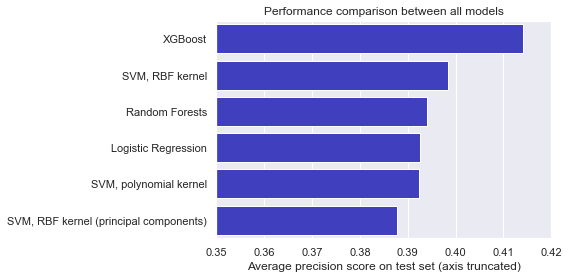

In [86]:
# Plot performance
model_names = ['XGBoost', 'SVM, RBF kernel',
               'Random Forests', 'Logistic Regression', 
               'SVM, polynomial kernel',
               'SVM, RBF kernel (principal components)']
sns.barplot(x=ap.values, y=model_names,
            orient='h',
            color='blue', saturation=.5)
plt.xlim(0.35,0.42)
plt.title('Performance comparison between all models')
plt.xlabel('Average precision score on test set (axis truncated)')
plt.show();

As we already knew, XGBoost far outperformed the other models.  Note that in the plot the x-axis does not start at zero, because this would give the misleading picture that the models perform all about equally. Even though XGBoost outperforms the other models only by 0.02, this is actually a substantial improvement, because getting the last boost in accuracy gets increasingly hard. The reason we know that this improvement is indeed noteworthy is that it is large compared to the variance in scores we observe between the rest of the models.

This visualization also allows a more nuanced comparison of the other learners. To start with, we see that using principal components did not pay off. Apparently, the information lost by reducing the dimensionality of the feature space more than outweighed the information gained by being able to use a bigger sample size. So let's focus on the other models estimated on the full data set from now on. 

Another observation is that the SVM with RBF kernel does perform substantially better than logistic regression, random forests, and the SVM with polynomial kernel.  It is reassuring that it was worth going to so great length (e.g., using AWS) to make training this model feasible. 

By contrast, using the polynomial kernel does not provide a similar increase in performance.  This is probably due to the fact that polynomials often behave erratically far away from the mean. Nevertheless, it likely was still worth it to train this model despite its considerable computational cost, because it gives us another set of predictions to use in the ensemble. The same can be said about the model trained on the principal components, because the key to deriving benefit from an ensemble is to get predictions that are not too correlated between the different models. 

## Ensemble

The final step is to combine all these different models into an ensemble in order to take advantage of the insights from the different learners. Ensembles have been shown to be a good way of decreasing both bias and variance of predictions without overfitting.  There are different ways of creating ensembles. The one I choose is a **hard voting classifier**.  This strategy simply takes a majority vote of the hard predictions (class labels) from the individual models.   
The disadvantage of this strategy is that we lose some information by converting probabilistic predictions to binary class labels before the vote.  It would thus be better if we could simply average the probabilities (soft voting classifier).  However, the problem is that SVMs return the distance from the separating hyperplane rather than probabilities.  While it is possible to estimate probabilities from this, this is computationally too expensive .

We will start by loading the true class labels from the test set, as well as our predictions.

In [3]:
# Load true target variable for test set
y_test = joblib.load('data_processed/y_test.joblib')

In [4]:
# Load predictions and combine them into a data frame
model_names = ['rf', 'lr', 'xgb', 
               'svm_rbf', 'svm_rbf_pc', 'svm_poly']              
y_preds = pd.DataFrame(
            {model_name: joblib.load(
                f'predictions_test/y_{model_name}_2.joblib')
                    for model_name in model_names})

As mentioned previously, it is important that the predictions of different models are not to highly correlated. Thus, let's plot these correlations.

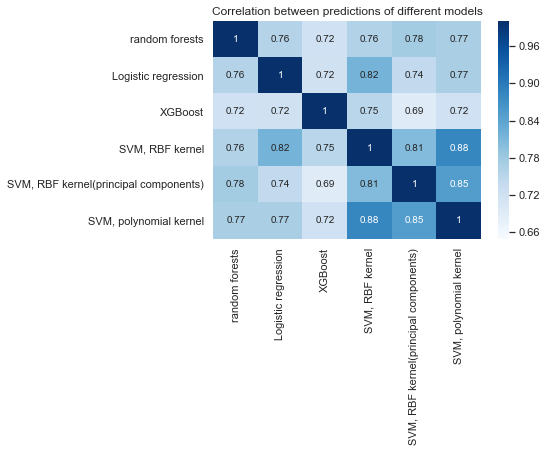

In [107]:
# Correlation between models
model_names = ['random forests', 'Logistic regression',
              'XGBoost', 'SVM, RBF kernel',
              'SVM, RBF kernel(principal components)',
              'SVM, polynomial kernel']
corr = y_preds.corr()
sns.heatmap(corr,
           annot=True,
           cmap='Blues',
           vmin=0.65,
           xticklabels=model_names,
           yticklabels=model_names)
plt.title('Correlation between predictions of different models')
plt.show()

This shows that the correlations range from 0.69 to 0.88. This means none of the models yield almost identical predictions, so we should get good results from averaging.  

Let's go ahead and compute the average.  For now, I will compute a simple average, except that I will weight XGBoost twice as much as the other models.  This is justified because it not only performs much better, but it's predictions are also less correlated with the other models. In addition, this avoids the possibility of ties (as we effectively go from averaging 6 to 7 models).

While one could develop an even more sophisticated weighting, deciding on how to compute the exact weights is challenging because these need to take into account not only a model's relative performance, but also the correlation of its predictions with other models.  Thus, I will go with the simpler solution describe above for now.

Scikit-learn implements a voting classifier, but it wasn't possible to use it here. The reason is that I relied on XGBoost's native API rather than the Scikit-learn API (since this allowed us to use a more optimized data format, amongst other). Since scikit-learn's voting classifier takes instances of the individual models as its arguments, I would not be possible to include XGBoost in the ensemble. 

However, implementing a hard voting classifier is straightforward. I start by taking the (weighted) average of the predictions for each test set observation. As explained above, we will double the weight of XGBoost.

In [121]:
# Compute average prediction for each opservation
y_pred_mean = np.average(y_preds.values, 
                         axis=1,
                         weights=[1, 1, 2, 1, 1, 1])

Let's take a look at the results:

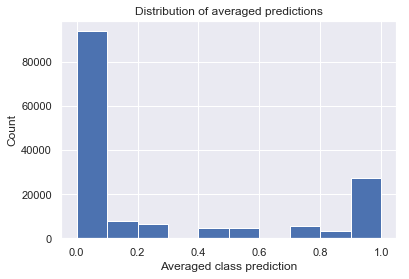

In [124]:
# Plot histograms
pd.Series(y_pred_mean) \
    .hist()
plt.title('Distribution of averaged predictions')
plt.xlabel('Averaged class prediction')
plt.ylabel('Count')
plt.show();

This shows that for the most part, the models agree that the applicant will default (scores near one) or not (scores near zero).  As already mentioned, we should not have any ties (0.5), but let's make sure just in case.

In [128]:
# Count the number of ties
(y_pred_mean==0.5).sum()

0

This confirms that there are in no ties.  The final step is to generate hard prediction from this average. We will use a threshold of 0.5, which corresponds to majority vote. (Remember that we already adjusted the trade-off between precision and recall when converting the soft predictions of the individual models into hard predictions.)

In [131]:
# Convert mean prediction to class label
y_pred = (y_pred_mean > 0.5) \
            .astype(int)

Let's compare the performance of this ensemble with the performance of the best model, XGBoost. Note that it does make sense to compute the average precision of a hard voting classifier (unless it averaged over a lot more models and thus gives a more continuous output), since doing so requires soft predictions.  Instead, we will look at precision and recall, as well as the F1-score. The latter is now a good summary of our model's performance: Since we already calibrated our class predictions to achieve a trade-off between precision and recall suitable to our business problem, we no longer need to take the classifier's performance on the whole precision-recall curve into account, but only care about its performance at the trade-off we chose.

In [144]:
# Performance of ensemble
print('Performance of ENSEMBLE:\n\n',
      classification_report(y_test, y_pred))

Performance of ENSEMBLE:

               precision    recall  f1-score   support

           0       0.86      0.79      0.83    122083
           1       0.39      0.50      0.44     31416

   micro avg       0.73      0.73      0.73    153499
   macro avg       0.62      0.65      0.63    153499
weighted avg       0.76      0.73      0.75    153499



In [145]:
# Performance of XGBoost
print('Performance of XGBOOST:\n\n',
      classification_report(y_test, y_preds.loc[:, 'xgb']))

Performance of XGBOOST:

               precision    recall  f1-score   support

           0       0.86      0.81      0.83    122083
           1       0.40      0.49      0.44     31416

   micro avg       0.74      0.74      0.74    153499
   macro avg       0.63      0.65      0.64    153499
weighted avg       0.77      0.74      0.75    153499



This shows that the ensemble performs very similar to XGBoost. Both achieve the same F1-score for identifying defaults (0.44) and non-defaults (0.83). When we take a more detailed look, we see that XGBoost performs slightly better on some measures (recall on non-default). Therefore, we would probably go with its predictions for making loan decisions for now. 

Nevertheless, the results do show the power of ensembles: Even though the other models - which performed considerably worse -  constituted 5/7 = 71% of the ensemble, the resulting accuracy is almost identical to XGBoost. By adding more different models, and by weighting the predictions in a more sophisticated way, we should be able to create an ensemble that surpasses the performance of the best individual model.

## Conclusion
Let's now reflect on lessons from this analysis.  Remember that the ultimate goal was to maximize predictive accuracy.

The first step to do so was to make sure that our data are clean, because this gets rid of noise that would otherwise increase the estimator's variance. This process also helped with getting to know the data better, which in turn allowed leveraging our domain knowledge to engineer better features. In particular, I normalized all monetary variables by dividing them by each applicant's income. While we don't know how much of a boost in accuracy each of these steps added, we do know that the new features I computed disproportionately ended up among the most important features.

However, an important lesson was that doing a good job cleaning the data takes a lot of time, so we have to ask beforehand whether we are willing to pay that extra cost in order to get a small boost in accuracy. The best solution may be to start out doing only a minimum amount of cleaning, and then jump into predictive modeling to get results as quickly as possible. We can then decide whether we are willing to invest extra time in order to get incremental improvements.

The same is true for feature engineering. It is worth pointing out that more sophisticated models such as XGBoost and random forests make less demands on the distribution of the data. For example, they are not affected by skewed distributions that are far from Gaussian. Since XGBoost ended up being the best performing model anyway, a quick first approach could limit feature engineering to a bare minimum to only address problems that these models are not able to deal with on their own (e.g., dividing the borrower's loan amount by their annual income, which drew on human domain knowledge).

During the predictive modeling stage, it again took a lot of extra effort in order to get the last increase in accuracy. Firstly, I needed to resort to Bayesian hyperparameter optimization in order to be able to optimize more than two or three hyperparameters. This more advanced technique was thus not strictly necessary for logistic regression and SVMs, but it proved vital for XGBoost, which had a lot of hyperparameters to optimize. The best alternative probably would have been to perform a lazy search, i.e. to sequentially tune one or two hyperparameters at a time. Needless to say, this would have caused us to take a performance hit on our best-performing model.
A second step I took during the predictive modeling stage was to run some of the models on AWS, most importantly in order to train an SVM with RBF kernel. While this algorithm turned out to yield the second best performing model, it still did not come close to XGBoost.
Finally, I combined all models into an ensemble using a hard voting classifier (weighting the predictions of XGBoost by a factor of two due to its superior performance). While this ensemble performed better than the (weighted) average of their individual scores, its performance came very close but did not reach the performance of XGBoost. Thus, we would want to go with XGBoost rather than the ensemble for actual predictions.

Overall, thus, a lot of extra effort was necessary in order to squeeze out the last bit of accuracy. On the other hand, as mentioned above, this is likely worth it for a problem such as this. In fact, a lending institution that is only slightly better at predicting its applicants’ default risk may derive such disproportionate results from this that it may be worth to keep fine-tuning the model even more.


## Future Scope
As hinted throughout the of the analysis, there are a number of additional steps we could take if you wanted to gain an additional increase in accuracy.  Most of these will be quite time-consuming, so they should only be taken if there are disproportionate gains from additional increases in accuracy.

Firstly, we dropped categorical variables with more than 50 categories, because one-hot encoding of these would create too many features. A better alternative would be to either seek to create binary variables for only the most relevant or most common categories, or to extract a common meaning from different categories (e.g., use natural language processing for text fields).
Secondly, as we discussed at length above, it would be good to take the time-series nature (i.e. temporally correlated errors) into account. However, coming up with representative training- and test sets is a huge challenge.
Thirdly, we could train a deep learning model, which is likely to outperform all other models.
Finally, we could simply add more independent models to the ensemble, or use a more sophisticated way of combining the predictions of the individual models.